Import the necessary library

In [ ]:
pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=bbbfc573a93d2a576a4064cb2d37f482b9aeb23e1af39d1dda9f9dc2371d7f04
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress
from pykalman import KalmanFilter

# **I.Basic Concepts of Pair Trading:**

*1) Graphic representation of basic idea*
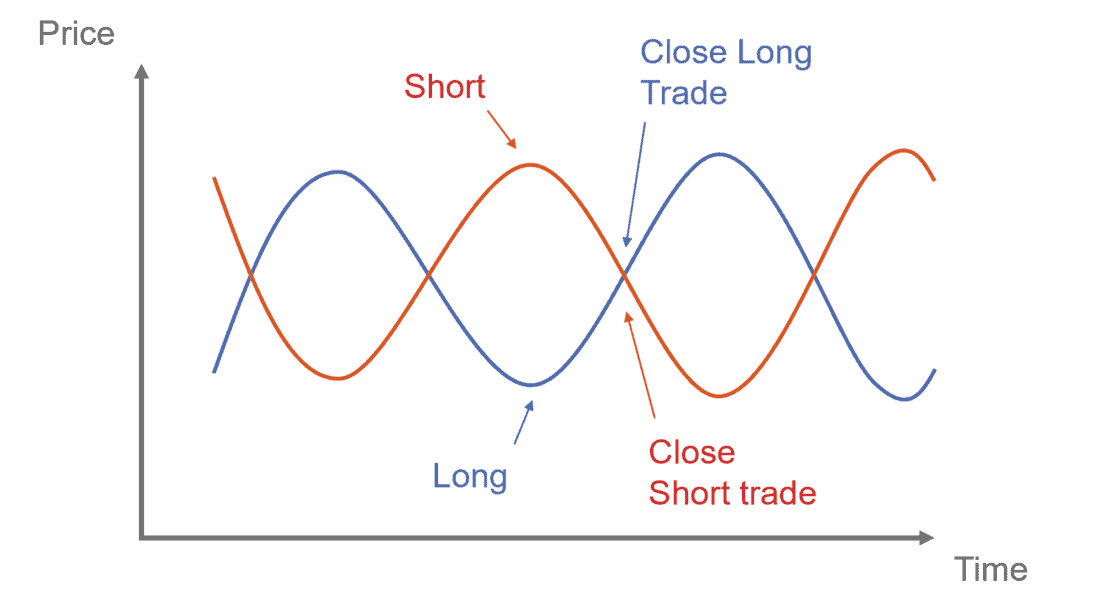*source: algotrading101.com*

The rationale behind is based on the belief that if two stocks behave very correlated in the past, then in the future this behaviour will likely to continue and any large deviation of the price of two stocks will be revered back.

*2) Hedge ratios?*

In pair trading, the hedge ratios denotes how many stock will you sell if you buy the other paired stock (to what degree will you hedge your position)

*3) How will it make money?*

Thus, one can make money by shorting the over priced stock and longing the under priced stock (long / short the spread) and by doing so, if the relation reverse, one will make money.

# **II. Use OLS to estimate the hedge ratio and alpha**

In [ ]:
#define the pair that will trade on
stocks = ["JPM","C"] #JPMorgan and C
start = '2020-08-01'
end = '2022-08-01'
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
  price = yf.download(stock,start,end)
  data[stock] = price['Adj Close']
  returns[stock] = np.append(data[stock][1:].reset_index(drop = True) / data[stock][:-1].reset_index(drop = True) - 1, 0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


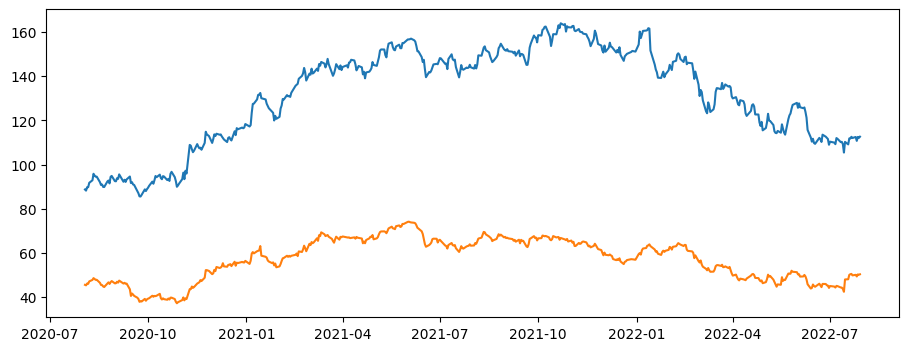

In [ ]:
#plot the paired stock data so visualize the possible cointergration
plt.figure(figsize = (11,4))
plt.plot(data['JPM'])
plt.plot(data['C'])

<ipython-input-5-8cc96fff6198>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['JPM'],data['C'],cmap='viridis')


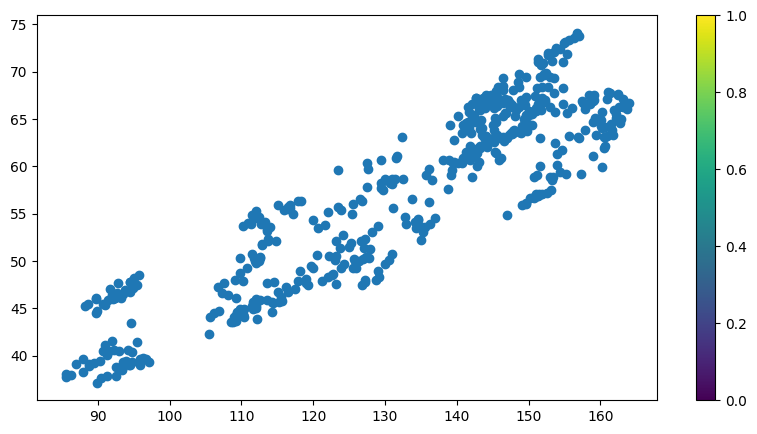

In [ ]:
#scatter plot of two stock to directly show the relationship
plt.figure(figsize = (10,5))
plt.scatter(data['JPM'],data['C'],cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
#calculate the spread using linear regression
x = np.log(data['JPM'])
x_const = sm.add_constant(x)
y = np.log(data['C'])
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()
results.summary()
#get the beta and alpha
beta = results.params[1]
alpha = results.params[0]
#so the equation is C = 0.513827*JPM - 3.0300753 and calculate the predicted C price
cvx_predicted = x*beta + alpha

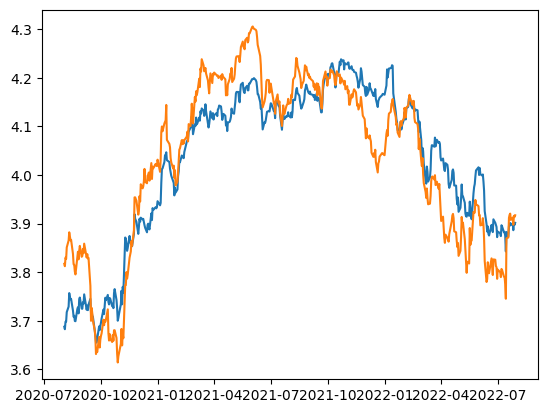

In [ ]:
plt.plot(cvx_predicted)
plt.plot(y)

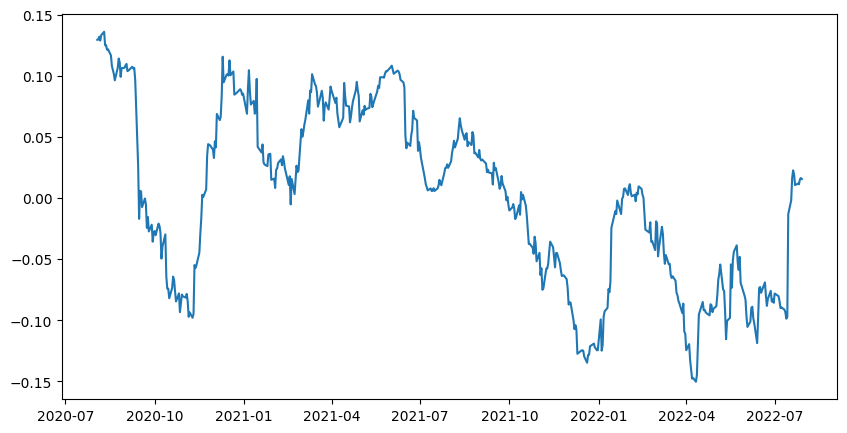

In [ ]:
# cacluate the spread of two stocks
spread = y - beta*x  - alpha
plt.figure(figsize = (10,5))
plt.plot(spread)

In [ ]:
# test the stationarity using ADF test to test if this series is actually conintergrated
spread = y - beta*x  - alpha
adf = ts.adfuller(spread)
adf

(-2.2667814633872427,
 0.18290547459028167,
 0,
 501,
 {'1%': -3.443470002903981,
  '5%': -2.867326248740681,
  '10%': -2.569851849873108},
 -2907.4829563427447)

In [ ]:
#Cointergration stock pairs identification class
class CointFinder():
  def __init__(self,start,end,stock,threshold):
    self.start = start
    self.end = end
    self.stock = stock
    self.threshold = threshold

  def coin_finder(self):
    conintegreated_pairs = []
    possibilities = []
    for i in range(len(self.stock)):
      for j in range(i+1,len(self.stock)):
        possibilities += [[self.stock[i],self.stock[j]]]
        stock1 = yf.download(self.stock[i],self.start,self.end)['Adj Close']
        stock2 = yf.download(self.stock[j],self.start,self.end)['Adj Close']
        x = np.log(stock1)
        x_const = sm.add_constant(x)
        y = np.log(stock2)
        linear_reg = sm.OLS(y,x_const)
        results = linear_reg.fit()
        beta = results.params[1]
        alpha = results.params[0]
        spread = y - beta*x  - alpha
        adf = ts.adfuller(spread)
        p_value = adf[1]
        if p_value <= self.threshold:
          conintegreated_pairs.append([self.stock[i],self.stock[j]])
        if conintegreated_pairs:
          return conintegreated_pairs
        else: 
          return "Pairs not founded based on the given time horizon and threshold "
pairs = CointFinder(start = '2020-08-01', end = '2022-08-01', stock = ['JPM','C','AAPL','AMZN','MSFT','CVX','XOM'], threshold = 0.1)
pairs.coin_finder()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


'Pairs not founded based on the given time horizon and threshold '

# **III. Kalman Filter Basic Concepts**

***1. Concept Introduction***

However, this beta (hedge ratio) finding method is problematic: since the beta should be varied across time instead of fixed beta, we should develop a more precise method to predict the beta and spread. Since for everyday the stock price change will lead to a different hedge ratio, we want to update the existing hedge ratio once the new information come in.

The KF (Kalman Filter) assumes a linear dynamics for the true state(or the "hidden variable" that one wants to estimate) $\mathbf x_k$ with $k \in \mathbb{N}$, and Normally distributed errors.    

$$
\begin{aligned}
\mathbf x_{k} &= \mathbf A_k \mathbf x_{k-1} + \mathbf w_k & \mbox{with}  \quad \mathbf w_k \sim \mathcal{N}(0, \mathbf Q_k)  \\
\mathbf z_k &=  \mathbf C_k \mathbf x_{k} + \mathbf v_k  & \mbox{with}  \quad \mathbf v_k \sim \mathcal{N}(0, \mathbf R_k)  \\
\\\end{aligned}
$$

The first equation is the **prediction equation** for the state (or the vairbale you want to estimate),
where $\mathbf A_k$ is the *state transition function* (or matrix) which tells you how the next phase of the variable will evolve, and $\mathbf w_k$ is the process noise with covariance $\mathbf Q_k$. 

The second equation is the **measurement equation**, where $\mathbf z_k$ are the measurement of the true state $\mathbf x_k$. The term $\mathbf C_k$ is the *measurement function* (or matrix), and $\mathbf v_k$ is the measurement noise with covariance $\mathbf R_k$. 

In general, it takes three main steps to dynamically update the hidden parameters:

*1) Predicion Step: also called state transition step*
$$\hat{\mathbf x}_{k\mid k-1} = \mathbf A_k\hat{\mathbf x}_{k-1\mid k-1}  + w_k \\ \mathbf P_{k\mid k-1} =  \mathbf A_k \mathbf P_{k-1\mid k-1} \mathbf A_k^\mathsf T + \mathbf Q_k$$

Here $F_k$ represents the transition matrix which means that how you expect your hidden variable will be in the next stage(time), with some noise  denoted by $w_k$.

$P_k$ here represents the state covariance matrix and it denotes the error in the prediction process. And it is always required estimation or empirical analysis based on the past data in $P_k$ --> how much you estimate the erros will be in the prediction process.

*2) Observation / measurement process*
$$\tilde{\mathbf y_k} = \mathbf z_k - \mathbf C_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k = \mathbf C_k \mathbf P_{k\mid k-1} \mathbf C_k^\mathsf T + \mathbf R_k\\
\mathbf K_k = \mathbf P_{k\mid k-1}\mathbf C_k^\mathsf T \mathbf{S}_k^{-1}$$

where $C_k$ represents the observation matrix, which is the actual observation / measurement one actaully take

Here, $\tilde{\mathbf y_k}$ represents the deviation from the true observation $z_k$ is the estimated value $\mathbf C_k\hat{\mathbf x}_{k\mid k-1}$. And $S_k$ represents the total error rate from both observation and measurement; and the kalman gain $K_k$ is calculated based on the amount of prediction error divided by the total error.

*3) Update and iteration process*
$$\hat{\mathbf x}_{k\mid k} = \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k \\
\mathbf P_{k|k} = (\mathbb{1} - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1} 
\\
\tilde{\mathbf y}_{k\mid k} = \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k} 
$$


***2. One dimensional Kalman Filter example***

Estimating the height of a building.

informations:

a) True building height is 50 m

b) The altimeter measurement error is assumed to be 5 m

c) The ten measurements from altimeter is 
[49.03, 48.44,55.21,49.98,50.6,52.61,45.87,42.64,48.26,55.84]

Step 1: Initialization

The prediction height is simply by looking at it, and the estimated error (std) is assumed to be 15m on average.
Thus, the initialization equation can be formatted as:
$$\hat{\mathbf x}_{0\mid 0} = 60m \\ \mathbf P_{0\mid 0} =  15^2 = 225m$$

Step 2: Prediction 

Since our eyeballing will not change the estimation through time, our next stage is just the previous stage, and the error is just the previous error as well.
Thus, the prediction equation can be expressed as:
$$\hat{\mathbf x}_{1\mid 0} = \hat{\mathbf x}_{0\mid 0} = 60m \\ 
\mathbf P_{1\mid 0} = \mathbf P_{0\mid 0} =  15^2 = 225m$$

Step 3: measurement 

The first measurement came in is 49.03 with std of 5 and the observation matrix is just [1], then the measurement equation can be expressed as:
$$\tilde{\mathbf y_k} = 49.03 - [1]*60 = -10.97\\
\mathbf{S}_k = [1]* 225 * [1] + 5^2 = 250\\
\mathbf K_k = {{225} \over {250}} = 0.9$$

Step 4: update 

$$\hat{\mathbf x}_{k\mid k} = 60 + 0.9*(-10.97) = 50.13 \\
\mathbf P_{k|k} = (1-0.9)*225 = 22.5
$$

Step 5: iteration

The python code that demonstrate this task is shown below.

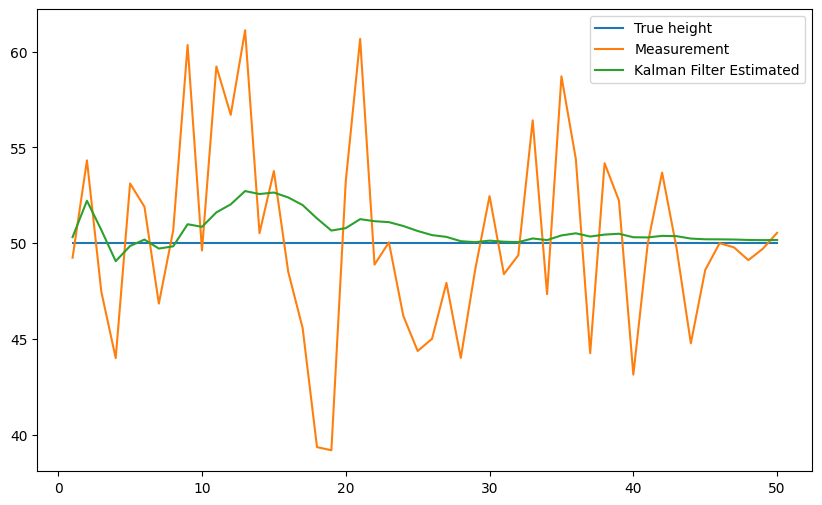

In [ ]:
#parameter definition
trueheight = 50
# measurement = np.array([49.03, 48.44,55.21,49.98,50.6,52.61,45.87,42.64,48.26,55.84])
measurement = np.random.normal(50, 5, 50)
P = np.array([225])
transition_matrix = np.array([1])
observation_matrix = np.array([1])
initial_guess = np.array([60])
R = np.array([25])

#kalman filter initialization
kf = KalmanFilter(
        n_dim_obs=1,  #only stock price in observed, so 1 dimension
        n_dim_state=1, #dimension of predicted parameter, in this case is alpha and beta so 2 dimensions
        initial_state_mean=initial_guess,
        initial_state_covariance=P,
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        observation_covariance=R,
        transition_covariance=0)
state_means, state_covs = kf.filter(measurement)

# graph the three relationships
plt.figure(figsize = (10,6))
y = np.array([i for i in range(1,51)])
true = np.array([50 for j in range(50)])
plt.plot(y,true, label = 'True height')
plt.plot(y,measurement, label = 'Measurement')
plt.plot(y,state_means, label = 'Kalman Filter Estimated')
plt.legend()
plt.show()

# **IV. An example transition of the Multi-dimensional Klamn Filter process with estimating regression coefficient $β$**

Now that we have seen the uni-dimensional version of Kalman Filter, now we arrived to the point to generalize the process in the matrix format with a concret example of regression.

In regression, we assume that the hidden variables, namely $\alpha$ and $\beta$, follows random walk, and the measurement equation is nothingg more than the regression equation itself. For the purpose of simplicity, lets assume that we are dealing with a simple OLS.

**Assumptions:**

a) Initial state covariance $P_0$ (prediction error) is estimated to be 1

b) The process noise (transition covariance) $Q_k$ is estimated to be 0.0001

c) The measurement noise $R_k$ is estimated to be 3.

d) The first measurement of x came in is 125.

e) The first labeled true value of y is 200

##### Process equation:
$$
\biggl(\begin{array}{c} \alpha\\ \beta_k \end{array}\biggr) = 
\biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)
\biggl(\begin{array}{c} \alpha\\ \beta_{k-1} \end{array}\biggr) 
+ \biggl(\begin{array}{c} 0\\ \eta_k \end{array}\biggr) \quad \mbox{with}  \quad 
\eta_k \sim \mathcal{N}(0, \sigma^2_{\eta}) $$

##### Measurement equation:
$$
y_k =   \bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) \biggl(\begin{array}{c} \alpha\\ \beta_k \end{array}\biggr)
+ \epsilon_k  \quad \mbox{with}  \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{\epsilon})  \\
$$

**Iteration 1:**

##### Predict:
$$ \biggl(\begin{array}{c} \alpha_1\\ \beta_1 \end{array}\biggr) = 
\biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)
\biggl(\begin{array}{c} \alpha_0\\ \beta_{0} \end{array}\biggr) 
= \biggl(\begin{array}{c} \alpha_0*1 + \beta_0*0 \\ \beta_0 *1 + \alpha_0*0 \end{array}\biggr)  = \biggl(\begin{array}{c} \alpha_0\\ \beta_0 \end{array}\biggr) \\
P_1 = \biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)* \biggl(\begin{array}{cc} 1 & 1\\ 1 & 1 \end{array}\biggr)*\biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)^T + \biggl(\begin{array}{cc} 0.0001 & 0\\ 0 & 0.0001 \end{array}\biggr) = \biggl(\begin{array}{cc} 1.0001 & 1\\ 1 & 1.0001 \end{array}\biggr)$$
##### Variables:
$$ r_1 = 200 - \alpha_1 - \beta_{1} *125  $$

$$ S_1 = \bigl(\begin{array}{cc} 1 & 125 \end{array}\bigr) 
\biggl(\begin{array}{cc} 1.0001 & 1\\ 1 & 1.0001 \end{array}\biggr)\biggl(\begin{array}{c} 1\\ 125 \end{array}\biggr) + 3
$$

$$ K_k = \frac{P_1}{S_1} $$
##### Update:
$$ \biggl(\begin{array}{c} \alpha\\ \beta_{k \mid k} \end{array}\biggr) =  
\biggl(\begin{array}{c} \alpha \\ \beta_{k \mid k-1} \end{array}\biggr) + \frac{1}{S_k} \biggl(\begin{array}{c} 0\\ r_k x_k P_{k \mid k-1} \end{array}\biggr)
$$

$$  \biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k} \end{array}\biggr) =  \biggl[
\biggl(\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\biggr)
- \frac{1}{S_k} \biggl(\begin{array}{c} 0\\ x_k P_{k \mid k-1} \end{array}\biggr)
\bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) \biggr] \biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k-1} \end{array}\biggr) 
$$

# **V. Terminology in Pykalman package**
1) transition_matrices --> $A_k$: state transition matrix between times t and t+1 for t in

2) observation_matrices --> $C_k$: observation matrix for times

3) transition_covariance --> $Q_k$: state transition covariance matrix for times

4) observation_covariance --> $R_k$: observation covariance matrix for times

5) initial_state_mean --> Also known as $\mu_0$. mean of initial state distribution

6) initial_state_covariance --> Also known as $P_k$. covariance of initial state distribution

In [ ]:
# Kalman Filter Pair trading CLASS
class KalmanFilterPairTrading():
  def __init__(self,stock1,stock2):
    self.stock1 = stock1
    self.stock2 = stock2
    # self.F = F   #state transition matrix A
    # self.P = P   #Initial covariance matirx of hidden variables P --> estimation
    # self.R = R   #Observation / measurement covariance / noise (v in measurement equation) --> estimation
    # self.delta = delta   #value to estimate the transition covariance (white noise w in transition process)  --> estimation
    self.data = None
    self.kf = None
    self.state_means = None
    self.state_covs = None

  def CointergrationCheck(self):
    x = np.log(self.stock1)
    x_const = sm.add_constant(x)
    y = np.log(self.stock2)
    linear_reg = sm.OLS(y,x_const)
    results = linear_reg.fit()
    beta = results.params[1]
    alpha = results.params[0]
    spread = y - beta*x  - alpha
    adf = ts.adfuller(spread)
    if adf[1] <= 0.05:
      return adf[1], True
    else:
      return False
  
  def KalmanFilterResults(self,F = np.eye(2), P = np.ones((2,2)),R = 0.1, delta = 1e-5):
    stockdata = pd.DataFrame()
    return1 = np.log(self.stock1)
    return2 = np.log(self.stock2)
    stockdata['Stock 1 price'] = self.stock1
    stockdata['Stock 1 return'] = return1
    stockdata['Stock 2 price'] = self.stock2
    stockdata['Stock 2 return'] = return2
    d = delta #initial random guess of delta
    trans_cov = d / (1 - d) * np.eye(2)
    obs_mat = np.vstack([np.ones(return1.shape),return1]).T[:, np.newaxis] #should be in the array of [1，stockreturn1]
    kf = KalmanFilter(
        n_dim_obs=1,  #only stock price in observed, so 1 dimension
        n_dim_state=2, #dimension of predicted parameter, in this case is alpha and beta so 2 dimensions
        initial_state_mean=np.zeros(2), #initial random guess of the alpha and beta
        initial_state_covariance=P, #prediction noise
        transition_matrices=F, #state transition matrix
        observation_matrices=obs_mat, #observation matrix
        observation_covariance=R, #measurement error
        transition_covariance=trans_cov #variance of prediction errors
    )
    self.kf = kf
    state_means, state_covs = kf.filter(return2)
    dynamic_spread = return2 - return1*state_means[:,0] - state_means[:,1]
    stockdata['slope'] = state_means[:,0]
    stockdata['alpha'] = state_means[:,1]
    stockdata['Dynamic Spread'] = dynamic_spread 
    self.data = stockdata
    self.state_means = state_means
    self.state_covs = state_covs
    return self.data

  def GetHedgeRatios(self):
    if self.data is None:
      self.KalmanFilterResults()
    return self.data['slope']
  
  def GetAlpha(self):
    if self.data is None:
      self.KalmanFilterResults()
    return self.data['alpha']

  def TradingSignals(self, moving = True,window_size = 20,threshold = 1.5):
    zz = self.KalmanFilterResults()
    if moving == True:
      zz['mean spread'] = zz['Dynamic Spread'].rolling(window_size).mean()
      zz['upper'] = zz['mean spread'] + threshold*zz['Dynamic Spread'].rolling(window_size).std()
      zz['lower'] = zz['mean spread'] - threshold*zz['Dynamic Spread'].rolling(window_size).std()
      zz['buy'] = zz['Dynamic Spread'][((zz['Dynamic Spread'] < zz['lower']) & (zz['Dynamic Spread'].shift(1) > zz['lower']) | 
                            (zz['Dynamic Spread'] <  zz['mean spread']) & (zz['Dynamic Spread'].shift(1) >  zz['mean spread']))]
      zz['sell'] = zz['Dynamic Spread'][((zz['Dynamic Spread'] > zz['upper']) & (zz['Dynamic Spread'].shift(1) < zz['upper']) | 
                                (zz['Dynamic Spread'] >  zz['mean spread']) & (zz['Dynamic Spread'].shift(1) <  zz['mean spread']))]
      zz.iloc[:,6:].plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])
    else:
      zz['mean spread'] = zz['Dynamic Spread'].mean()
      zz['upper'] = zz['mean spread'] + threshold*zz['Dynamic Spread'].std()
      zz['lower'] = zz['mean spread'] - threshold*zz['Dynamic Spread'].std()
      zz['buy'] = zz['Dynamic Spread'][((zz['Dynamic Spread'] < zz['lower']) & (zz['Dynamic Spread'].shift(1) > zz['lower']) | 
                            (zz['Dynamic Spread'] <  zz['mean spread']) & (zz['Dynamic Spread'].shift(1) >  zz['mean spread']))]
      zz['sell'] = zz['Dynamic Spread'][((zz['Dynamic Spread'] > zz['upper']) & (zz['Dynamic Spread'].shift(1) < zz['upper']) | 
                                (zz['Dynamic Spread'] >  zz['mean spread']) & (zz['Dynamic Spread'].shift(1) <  zz['mean spread']))]
      zz.iloc[:,6:].plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])
    self.zz = zz
    return self.zz
  def Update(self,newstock1 = np.array([100]), newstock2=np.array([[1,200]])):
    if (self.state_means and self.stat_covs and self.kf) is None:
      self.KalmanFilterResults()
      state_means_stepwise, state_covs_stepwise = self.kf.filter_update(
          self.state_means[-1], self.state_covs[-1],
          observation=newstock1,
          observation_matrix=newstock2)
      return state_means_stepwise, state_covs_stepwise
  
  def Halflife(self): # on average how long will the spread mean revert
    if self.data is None:
      self.KalmanFilterResults()
      spread = self.data['Dynamic Spread']
      lag = spread.shift(1)
      lag.iloc[0] = lag.iloc[1]
      returns = spread - lag
      returns.iloc[0] = returns.iloc[1]
      spread_lag2 = sm.add_constant(lag)
      model = sm.OLS(returns,spread_lag2)
      res = model.fit()
      halflife = int(round(-np.log(2) / res.params[1],0))
      if halflife <= 0:
        halflife = 1
    return halflife

  def Backtest(self):
    if self.data is None:
        self.KalmanFilterResults()
    signals = self.TradingSignals()
    positions = pd.Series(index=signals.index, data=np.zeros(len(signals)))
    positions[signals['buy'] > 0] = 1
    positions[signals['sell'] > 0] = -1
    hedge_ratios = self.GetHedgeRatios()
    ret = (self.data['Dynamic Spread'] - self.data['Dynamic Spread'].shift(1)) / (hedge_ratios * (self.stock1.pct_change()) + self.stock2.pct_change())
    returns = ret*positions.shift(1)
    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod()

    return cumulative_returns[-1]


0.0802972705864077

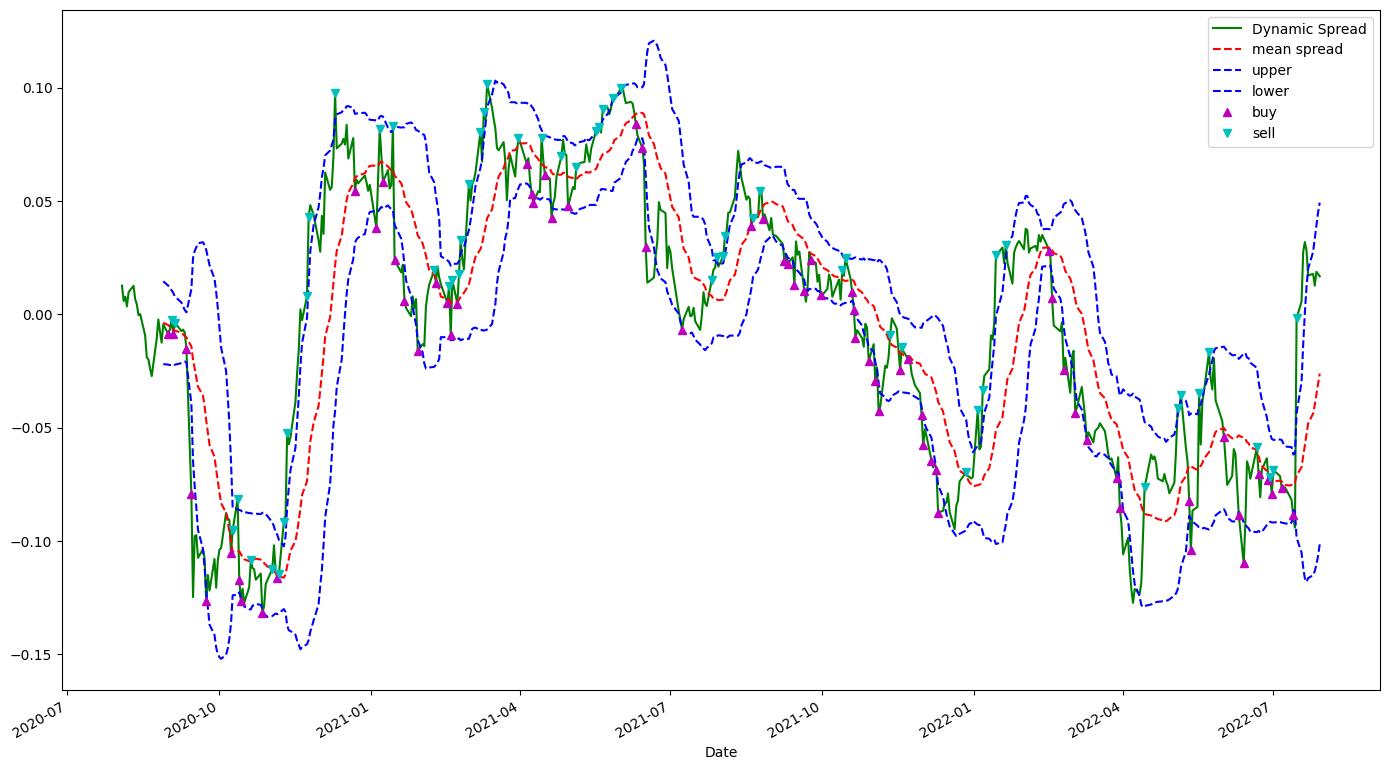

In [ ]:
x1 = KalmanFilterPairTrading(data['JPM'], data['C'])
x1.Backtest()

# **Reference**

[1] *Kalman Filter Tutorial* https://www.kalmanfilter.net/default.aspx